100%|██████████| 9.91M/9.91M [00:00<00:00, 101MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 44.8MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 74.6MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 1.49MB/s]


Train Epoch: 0 [0/60000 (0%)]	Loss: 556.727905
Train Epoch: 0 [12800/60000 (21%)]	Loss: 203.391876
Train Epoch: 0 [25600/60000 (43%)]	Loss: 187.196075
Train Epoch: 0 [38400/60000 (64%)]	Loss: 156.946075
Train Epoch: 0 [51200/60000 (85%)]	Loss: 138.255875
Train Epoch: 1 [0/60000 (0%)]	Loss: 131.676147
Train Epoch: 1 [12800/60000 (21%)]	Loss: 129.392700
Train Epoch: 1 [25600/60000 (43%)]	Loss: 125.861961
Train Epoch: 1 [38400/60000 (64%)]	Loss: 115.565765
Train Epoch: 1 [51200/60000 (85%)]	Loss: 118.963684
Train Epoch: 2 [0/60000 (0%)]	Loss: 117.467613
Train Epoch: 2 [12800/60000 (21%)]	Loss: 114.057465
Train Epoch: 2 [25600/60000 (43%)]	Loss: 116.740135
Train Epoch: 2 [38400/60000 (64%)]	Loss: 112.373779
Train Epoch: 2 [51200/60000 (85%)]	Loss: 113.583519
Train Epoch: 3 [0/60000 (0%)]	Loss: 107.951004
Train Epoch: 3 [12800/60000 (21%)]	Loss: 107.126595
Train Epoch: 3 [25600/60000 (43%)]	Loss: 111.923767
Train Epoch: 3 [38400/60000 (64%)]	Loss: 104.494873
Train Epoch: 3 [51200/60000 (85%

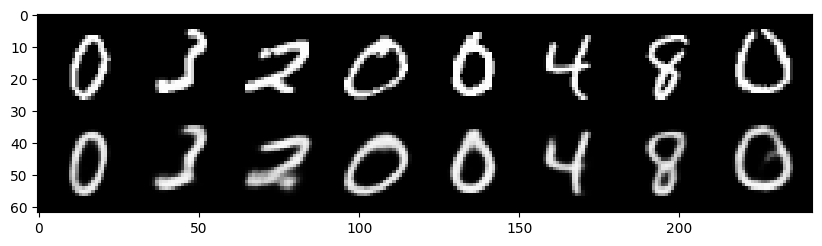

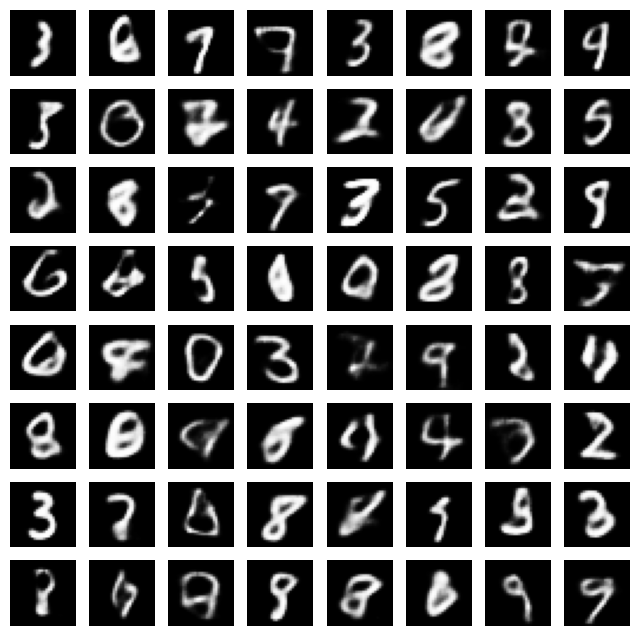

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

# Load MNIST dataset
transform = transforms.ToTensor()
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)

# ConvVAE model
class ConvVAE(nn.Module):
    def __init__(self, latent_dim=20):
        super(ConvVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32 * 7 * 7, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim * 2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 32 * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (32, 7, 7)),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.encoder(x)
        mu, logvar = h.chunk(2, dim=1)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

# Loss function and training loop
model = ConvVAE(latent_dim=20)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def loss_function(recon_x, x, mu, logvar):
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss

def train(epoch):
    model.train()
    for batch_idx, (data, _) in enumerate(train_loader):
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')

# Visualization of generated images and latent space
def visualize_results(model, data_loader, device='cpu'):
    model.eval()
    with torch.no_grad():
        data, _ = next(iter(data_loader))
        recon_batch, mu, logvar = model(data.to(device))
        n = min(data.size(0), 8)
        comparison = torch.cat([data[:n], recon_batch.view(data.size(0), 1, 28, 28)[:n]])
        plt.figure(figsize=(10, 5))
        plt.imshow(torchvision.utils.make_grid(comparison).cpu().numpy().transpose((1, 2, 0)))
        plt.show()

        # Latent space visualization
        z = torch.randn(64, 20).to(device)
        generated = model.decoder(z).view(64, 28, 28).cpu().detach().numpy()
        plt.figure(figsize=(8, 8))
        for i in range(generated.shape[0]):
            plt.subplot(8, 8, i + 1)
            plt.imshow(generated[i], cmap='gray')
            plt.axis('off')
        plt.show()

for epoch in range(10):
    train(epoch)
visualize_results(model, train_loader)